## Install packages

In [10]:
!pip install swig
!pip install "gymnasium[box2d]"
!pip install gymnasium gymnasium[box2d] stable-baselines3 torch pyvirtualdisplay moviepy
!apt-get install -y xvfb python-opengl ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 4.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


## Import and create LunarLander

## Action Space
There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine


## Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

## Rewards
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

is increased/decreased the closer/further the lander is to the landing pad.

is increased/decreased the slower/faster the lander is moving.

is decreased the more the lander is tilted (angle not horizontal).

is increased by 10 points for each leg that is in contact with the ground.

is decreased by 0.03 points each frame a side engine is firing.

is decreased by 0.3 points each frame the main engine is firing.




In [5]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

env = gym.make("LunarLander-v3", wind_power=15.0, turbulence_power=1.5)
obs, info = env.reset(seed=0)

print("Obs shape:", obs.shape)
print("Action space:", env.action_space)



Obs shape: (8,)
Action space: Discrete(4)


In [2]:
seed = 0
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)

env.reset(seed=seed)
env.action_space.seed(seed)

0

## Actor Critic

Implement:

1. Policy network
2. Value network
3. Advantage
4. Train 1 gradient update per batch

In [8]:
class PolicyNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(8, 128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 4)
    self.stack = nn.Sequential(self.fc1, self.relu, self.fc2)
  def forward(self, x):
    x =  self.stack(x)
    return x

class ValueNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(8, 128), nn.ReLU(), nn.Linear(128, 1))
  def forward(self, x):
    return self.net(x).squeeze(-1)



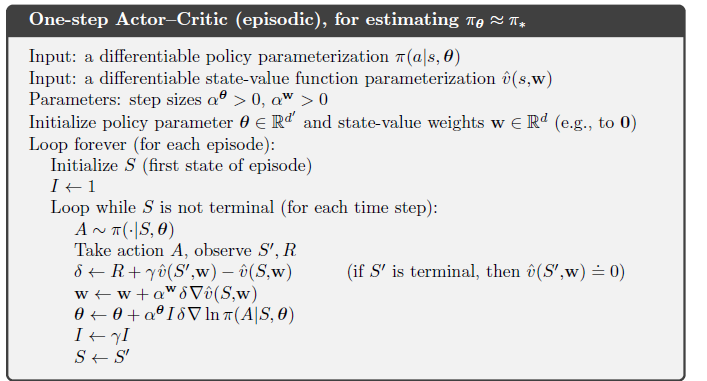

In [11]:
from torch.distributions import Categorical

value_model = ValueNetwork()
policy_model = PolicyNetwork()

env = gym.make("LunarLander-v3", render_mode="rgb_array")
policy_opt = optim.Adam(policy_model.parameters(), lr=3e-4)
value_opt = optim.Adam(value_model.parameters(), lr=1e-3)

gamma = 0.99
max_steps = 500
print_every = 10
episode_returns = []
episode_actor_losses = []
episode_critic_losses = []
episode_total_losses = []


for ep in range(1000) :
  state, info = env.reset()
  actor_loss_sum = 0.0
  critic_loss_sum = 0.0
  total_loss_sum = 0.0
  steps = 0

  ep_ret = 0.0
  for t in range(max_steps):

    action_logits = policy_model(torch.tensor(state, dtype = torch.float32))
    dist = Categorical(logits = action_logits)

    action = dist.sample()
    log_prob = dist.log_prob(action)

    next_state, reward, terminated, truncated, info = env.step(action.item())

    cur_value = value_model(torch.tensor(state, dtype = torch.float32)).squeeze()

    ep_ret += reward

    if terminated or truncated :
      next_value =torch.zeros_like(cur_value)
    else :
      next_value = value_model(torch.tensor(next_state, dtype = torch.float32)).squeeze().detach()

    delta = reward + gamma * next_value - cur_value

    actor_loss = -(log_prob * delta.detach())
    critic_loss = 0.5 *  (delta ** 2 )

    loss = actor_loss + critic_loss

    policy_opt.zero_grad()
    value_opt.zero_grad()
    loss.backward()
    policy_opt.step()
    value_opt.step()
    actor_loss_sum += actor_loss.detach().item()
    critic_loss_sum += critic_loss.detach().item()
    total_loss_sum += loss.detach().item()
    steps += 1

    state = next_state

    if terminated or truncated:
      break
  episode_returns.append(ep_ret)
  episode_actor_losses.append(actor_loss_sum / max(steps, 1))
  episode_critic_losses.append(critic_loss_sum / max(steps, 1))
  episode_total_losses.append(total_loss_sum / max(steps, 1))

  if (ep + 1) % print_every == 0:
      avg_ret_100 = np.mean(episode_returns[-100:])
      print(
          f"ep {ep+1:4d} | return {ep_ret:8.1f} | avg100 {avg_ret_100:8.1f} | "
          f"actor {episode_actor_losses[-1]:9.4f} | critic {episode_critic_losses[-1]:9.4f} | total {episode_total_losses[-1]:9.4f}"
      )


ep   10 | return   -479.5 | avg100   -284.2 | actor   -2.0620 | critic   16.8503 | total   14.7883
ep   20 | return    -61.8 | avg100   -336.6 | actor    0.0850 | critic    7.4187 | total    7.5037
ep   30 | return   -109.3 | avg100   -298.8 | actor   -0.8350 | critic   17.7969 | total   16.9619
ep   40 | return   -190.7 | avg100   -268.9 | actor   -1.1753 | critic   18.0994 | total   16.9241
ep   50 | return    -50.7 | avg100   -232.9 | actor   -0.4896 | critic    9.6206 | total    9.1310
ep   60 | return   -105.2 | avg100   -214.4 | actor   -0.3144 | critic   68.0719 | total   67.7574
ep   70 | return     -4.1 | avg100   -185.7 | actor   -0.4321 | critic    1.9877 | total    1.5556
ep   80 | return    -54.7 | avg100   -166.3 | actor   -0.5793 | critic    1.4574 | total    0.8780
ep   90 | return    -64.1 | avg100   -152.5 | actor   -0.5428 | critic    1.2937 | total    0.7508
ep  100 | return    -21.7 | avg100   -139.6 | actor   -0.3355 | critic    0.9938 | total    0.6583
ep  110 | 

## [Proximal Policy Optimization](https://arxiv.org/pdf/1707.06347)

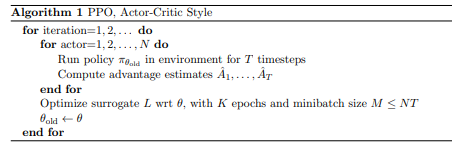

In [12]:
@torch.no_grad()
def compute_gae(rewards, dones, values, last_value, gamma=0.99, lam=0.95):
    """
    rewards: [T]
    dones:   [T]  (1.0 if done else 0.0)
    values:  [T]
    last_value: scalar V(s_T) for bootstrapping
    """
    T = len(rewards)
    adv = torch.zeros(T, dtype=torch.float32)
    gae = 0.0
    for t in reversed(range(T)):
        next_nonterminal = 1.0 - dones[t]
        next_value = last_value if t == T - 1 else values[t + 1]
        delta = rewards[t] + gamma * next_value * next_nonterminal - values[t]
        gae = delta + gamma * lam * next_nonterminal * gae
        adv[t] = gae
    returns = adv + values
    return adv, returns

In [13]:
## rollout collection

@torch.no_grad()
def rollout(env, policy, value, T=2048):
    obs_list, act_list, rew_list, done_list, logp_list, val_list = [], [], [], [], [], []
    ep_returns = []
    ep_ret = 0.0

    obs, info = env.reset()

    for _ in range(T):
      s = torch.tensor(obs, dtype=torch.float32)

      logits = policy(s)
      dist = Categorical(logits=logits)
      action = dist.sample()
      logp = dist.log_prob(action)

      v = value(s)

      next_obs, reward, terminated, truncated, info = env.step(action.item())

      done = terminated or truncated


      obs_list.append(s)
      act_list.append(action)
      rew_list.append(torch.tensor(reward, dtype=torch.float32))
      done_list.append(torch.tensor(1.0 if done else 0.0, dtype=torch.float32))
      logp_list.append(logp)
      val_list.append(v)

      ep_ret += reward
      obs = next_obs

      if done :
        ep_returns.append(ep_ret)
        ep_ret = 0.0
        obs, info = env.reset()
    ## bootstrap last value from current obs
    s_last = torch.tensor(obs, dtype=torch.float32)
    last_value = value(s_last)

    batch = {
        "obs": torch.stack(obs_list),          # [T, obs_dim]
        "acts": torch.stack(act_list),         # [T]
        "rews": torch.stack(rew_list),         # [T]
        "dones": torch.stack(done_list),       # [T]
        "logp_old": torch.stack(logp_list),    # [T]
        "vals": torch.stack(val_list),         # [T]
        "last_value": last_value               # scalar
    }
    return batch, ep_returns


In [14]:
def ppo_update(policy, value, optimizer, batch, gamma=0.99, lam=0.95, eps=0.2,
               epochs=10, minibatch_size=64, vf_coef=0.5, max_grad_norm=0.5):

  obs = batch["obs"]
  acts = batch["acts"]
  rews = batch["rews"]
  dones = batch["dones"]
  logp_old = batch["logp_old"]
  vals = batch["vals"]
  last_value = batch["last_value"]
  with torch.no_grad():
      adv, returns = compute_gae(rews, dones, vals, last_value, gamma=gamma, lam=lam)
      adv = (adv - adv.mean()) / (adv.std() + 1e-8)
  T = obs.shape[0]
  idxs = np.arange(T)
  total_pi_loss = 0.0
  total_v_loss = 0.0
  total_kl = 0.0
  total_clipfrac = 0.0
  n_batches = 0

  for _ in range(epochs) :
    np.random.shuffle(idxs)

    for start in range(0, T, minibatch_size) :
      mb_idx = idxs[start:start+minibatch_size]
      mb_obs = obs[mb_idx]
      mb_acts = acts[mb_idx]
      mb_adv = adv[mb_idx]
      mb_ret = returns[mb_idx]
      mb_logp_old = logp_old[mb_idx]

      logits = policy(mb_obs)
      dist = Categorical(logits=logits)
      logp = dist.log_prob(mb_acts)

      ratio = torch.exp(logp - mb_logp_old)

      surr1 = ratio * mb_adv
      surr2 = torch.clamp(ratio, 1.0 - eps, 1.0 + eps) * mb_adv
      pi_loss = -torch.mean(torch.min(surr1, surr2))

      v_pred = value(mb_obs)
      v_loss = 0.5 * torch.mean((v_pred - mb_ret) ** 2)

      loss = pi_loss + vf_coef * v_loss

      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(list(policy.parameters()) + list(value.parameters()), max_grad_norm)
      optimizer.step()

      with torch.no_grad():
          approx_kl = torch.mean(mb_logp_old - logp).item()
          clipfrac = torch.mean((torch.abs(ratio - 1.0) > eps).float()).item()

      total_pi_loss += pi_loss.item()
      total_v_loss += v_loss.item()
      total_kl += approx_kl
      total_clipfrac += clipfrac
      n_batches += 1

  stats = {
        "pi_loss": total_pi_loss / max(n_batches, 1),
        "v_loss": total_v_loss / max(n_batches, 1),
        "approx_kl": total_kl / max(n_batches, 1),
        "clipfrac": total_clipfrac / max(n_batches, 1),
    }
  return stats


In [22]:
env = gym.make("LunarLander-v3")
policy = PolicyNetwork()
value = ValueNetwork()
optimizer = optim.Adam(list(policy.parameters()) + list(value.parameters()), lr=3e-4)

iterations = 1000
T = 2048
epochs = 10
minibatch = 64
gamma = 0.99
lam = 0.95
eps = 0.2
episode_return_history = []


for it in range(1, iterations + 1) :
  batch, ep_rets = rollout(env, policy, value, T = T)

  episode_return_history.extend(ep_rets)

  stats = ppo_update(policy, value, optimizer, batch, gamma = gamma, lam = lam, eps= eps,
                     epochs = epochs, minibatch_size = minibatch, vf_coef = 0.5, max_grad_norm = 0.5)

  if it % 10 == 0:
        avg100 = np.mean(episode_return_history[-100:]) if len(episode_return_history) >= 100 else np.mean(episode_return_history) if len(episode_return_history) else 0.0
        last = episode_return_history[-1] if len(episode_return_history) else 0.0
        print(
            f"it {it:4d} | last_ret {last:7.1f} | avg100 {avg100:7.1f} | "
            f"pi {stats['pi_loss']:+.4f} | v {stats['v_loss']:.4f} | "
            f"kl {stats['approx_kl']:.4f} | clip {stats['clipfrac']:.3f}"
        )

env.close()

it   10 | last_ret   204.2 | avg100   186.4 | pi -0.0026 | v 76.3702 | kl 0.0016 | clip 0.022
it   20 | last_ret    97.5 | avg100   188.4 | pi -0.0024 | v 14.7981 | kl 0.0012 | clip 0.035
it   30 | last_ret   -46.4 | avg100   194.1 | pi -0.0021 | v 45.3818 | kl 0.0048 | clip 0.040
it   40 | last_ret   292.3 | avg100   191.8 | pi -0.0017 | v 63.6128 | kl 0.0039 | clip 0.043
it   50 | last_ret   303.2 | avg100   197.4 | pi -0.0026 | v 32.2399 | kl 0.0036 | clip 0.013
it   60 | last_ret   116.9 | avg100   199.6 | pi -0.0031 | v 27.5494 | kl 0.0025 | clip 0.052
it   70 | last_ret   228.3 | avg100   177.7 | pi -0.0056 | v 59.1448 | kl 0.0052 | clip 0.059
it   80 | last_ret    89.5 | avg100   164.6 | pi -0.0025 | v 28.5987 | kl 0.0004 | clip 0.017
it   90 | last_ret   312.4 | avg100   199.0 | pi -0.0057 | v 18.9880 | kl 0.0090 | clip 0.085
it  100 | last_ret   245.0 | avg100   222.4 | pi -0.0010 | v 30.5071 | kl 0.0034 | clip 0.019
it  110 | last_ret   299.0 | avg100   230.0 | pi -0.0019 | v

In [23]:
import gymnasium as gym
import torch
import numpy as np
import imageio.v2 as imageio
import cv2
from torch.distributions import Categorical

ACTION_NAMES = {
    0: "NO-OP",
    1: "LEFT",
    2: "MAIN",
    3: "RIGHT"
}

def record_trained_policy(
    policy,
    path="lunarlander_trained_model_final.mp4",
    env_id="LunarLander-v3",
    max_steps=1000,
    fps=30,
    greedy=True,
    seed=0,
    overlay=True
):
    """
    Records one episode of a trained policy in LunarLander and saves an MP4.

    Args:
        policy: torch nn.Module mapping state -> logits (shape [4])
        path: output mp4 path
        env_id: gymnasium env id
        max_steps: cap episode length
        fps: frames per second for video
        greedy: if True use argmax action, else sample
        seed: env seed for reproducibility
        overlay: if True overlays action + step + return on frames
    """
    env = gym.make(env_id, render_mode="rgb_array")
    policy.eval()

    frames = []
    obs, info = env.reset(seed=seed)
    done = False
    ep_ret = 0.0
    t = 0

    with torch.no_grad():
        while not done and t < max_steps:
            frame = env.render()

            s = torch.tensor(obs, dtype=torch.float32)
            logits = policy(s)
            dist = Categorical(logits=logits)

            if greedy:
                action = int(torch.argmax(dist.probs).item())
            else:
                action = int(dist.sample().item())

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_ret += float(reward)

            if overlay:
                frame = frame.copy()
                cv2.putText(
                    frame,
                    f"t={t:04d}  a={ACTION_NAMES[action]}  R={ep_ret:7.1f}",
                    (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.0,
                    (255, 255, 255),
                    2,
                    cv2.LINE_AA
                )

            frames.append(frame)
            t += 1

    env.close()

    # write mp4
    imageio.mimsave(path, frames, fps=fps)
    print(f"Saved: {path} | return: {ep_ret:.1f} | steps: {t}")


In [24]:
record_trained_policy(policy)

Saved: lunarlander_trained_model_final.mp4 | return: 308.5 | steps: 178
